In [1]:
#Essential libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [24]:
#Saving variables for later using
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
#Tensorflow dataset directory
dataset=tf.keras.utils.image_dataset_from_directory(
    'images',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3790 files belonging to 5 classes.


In [4]:
#Explore classes
CLASS_NAMES=dataset.class_names
CLASS_NAMES

['bed', 'diningtable', 'door', 'laptop', 'smartphone']

In [7]:
#images in each batch
len(dataset)

119

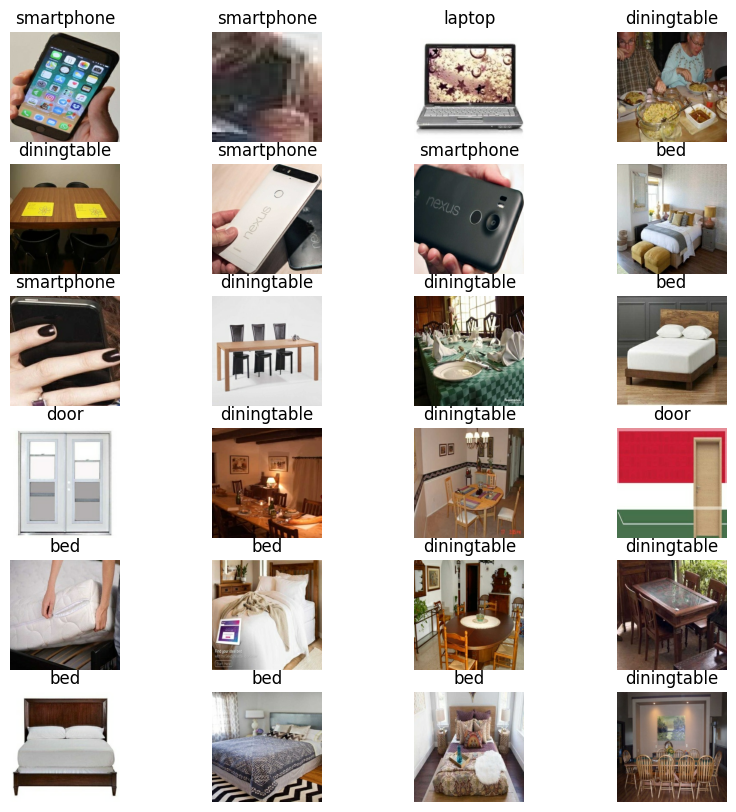

In [11]:
#Visualize the dataset
for image_batch,label_batch in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(24):
        ax=plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(CLASS_NAMES[label_batch[i]])
        plt.axis('off')

In [12]:
#Split training dataset into train,test,val
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=1)
    train_size=int(ds_size * train_split)
    val_size=int(ds_size * val_split)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [15]:
#Set train,test,val for further training
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)
print(len(dataset))
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

119
95
11
13


In [16]:
#For fast performance
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
#Resize and rescale
resize_and_rescale=keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255,),
])

In [18]:
data_augmentation = keras.Sequential([
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal_and_vertical")
])

In [21]:
#Create model
INPUT_SHAPE=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

In [22]:
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 60, 60, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 30, 30, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 28, 28, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 14, 14, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 25088)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 128)              │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 5)                │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,462,725 (13.21 MB)

 Trainable params: 3,462,725 (13.21 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Compile model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [25]:
#Train model
history=model.fit(train_ds,epochs=EPOCHS,validation_data=val_ds,batch_size=BATCH_SIZE)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - accuracy: 0.5460 - loss: 1.1864 - val_accuracy: 0.6165 - val_loss: 1.0161
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.6688 - loss: 0.9165 - val_accuracy: 0.6733 - val_loss: 0.8632
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.7131 - loss: 0.7986 - val_accuracy: 0.7074 - val_loss: 0.7657
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.7488 - loss: 0.7263 - val_accuracy: 0.6534 - val_loss: 0.9720
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.7525 - loss: 0.6898 - val_accuracy: 0.7358 - val_loss: 0.7305
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.7690 - loss: 0.6458 - val_accuracy: 0.7642 - val_loss: 0.6390
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7813 - loss: 0.6066 - val_accuracy: 0.7955 - val_loss: 0.5693
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.7919 - loss: 0.5673 - val_accuracy: 0.7926 - v

In [26]:
scores=model.evaluate(test_ds)
scores

13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7692 - loss: 0.6003


[0.6003237366676331, 0.7692307829856873]

In [27]:
history.params


{'verbose': 'auto', 'epochs': 10, 'steps': 95}

In [28]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

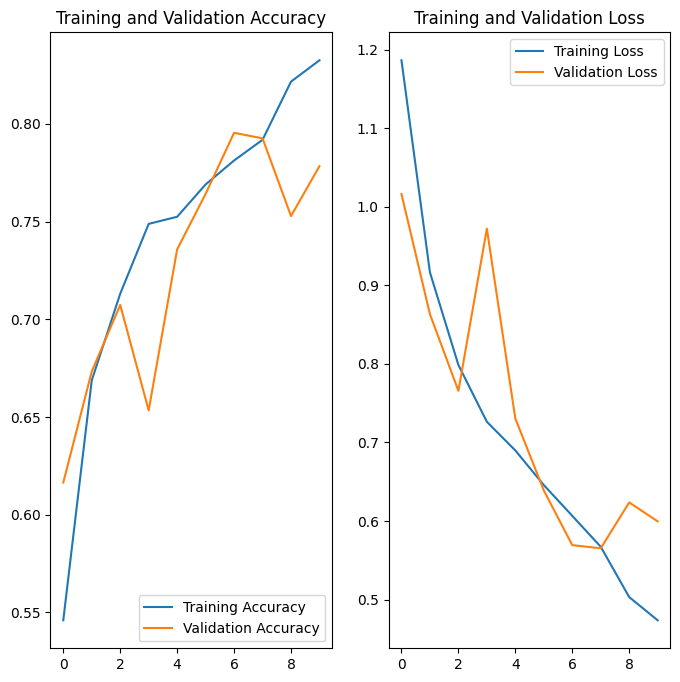

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First Image to Predict
Actual Label diningtable
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Predicted Label diningtable


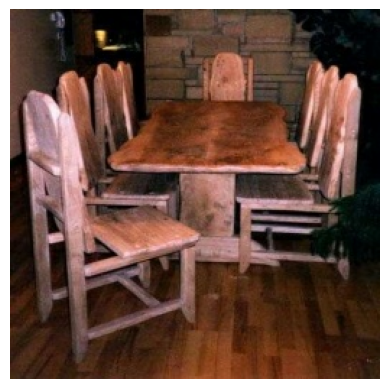

In [32]:
# One image Prediction
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print("First Image to Predict")
    plt.imshow(first_image)
    print("Actual Label",CLASS_NAMES[first_label])
    batch_prediction=model.predict(image_batch)
    print('Predicted Label',CLASS_NAMES[np.argmax(batch_prediction[0])])
    plt.axis('off')

In [34]:
#Prediction Function
def predict(model,img):
    img_array=np.expand_dims(img,axis=0)
    predictions=model.predict(img_array)
    predicted_index=np.argmax(predictions[0])
    predicted_class=CLASS_NAMES[predicted_index]
    confidence=round(100*np.max(predictions[0]),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


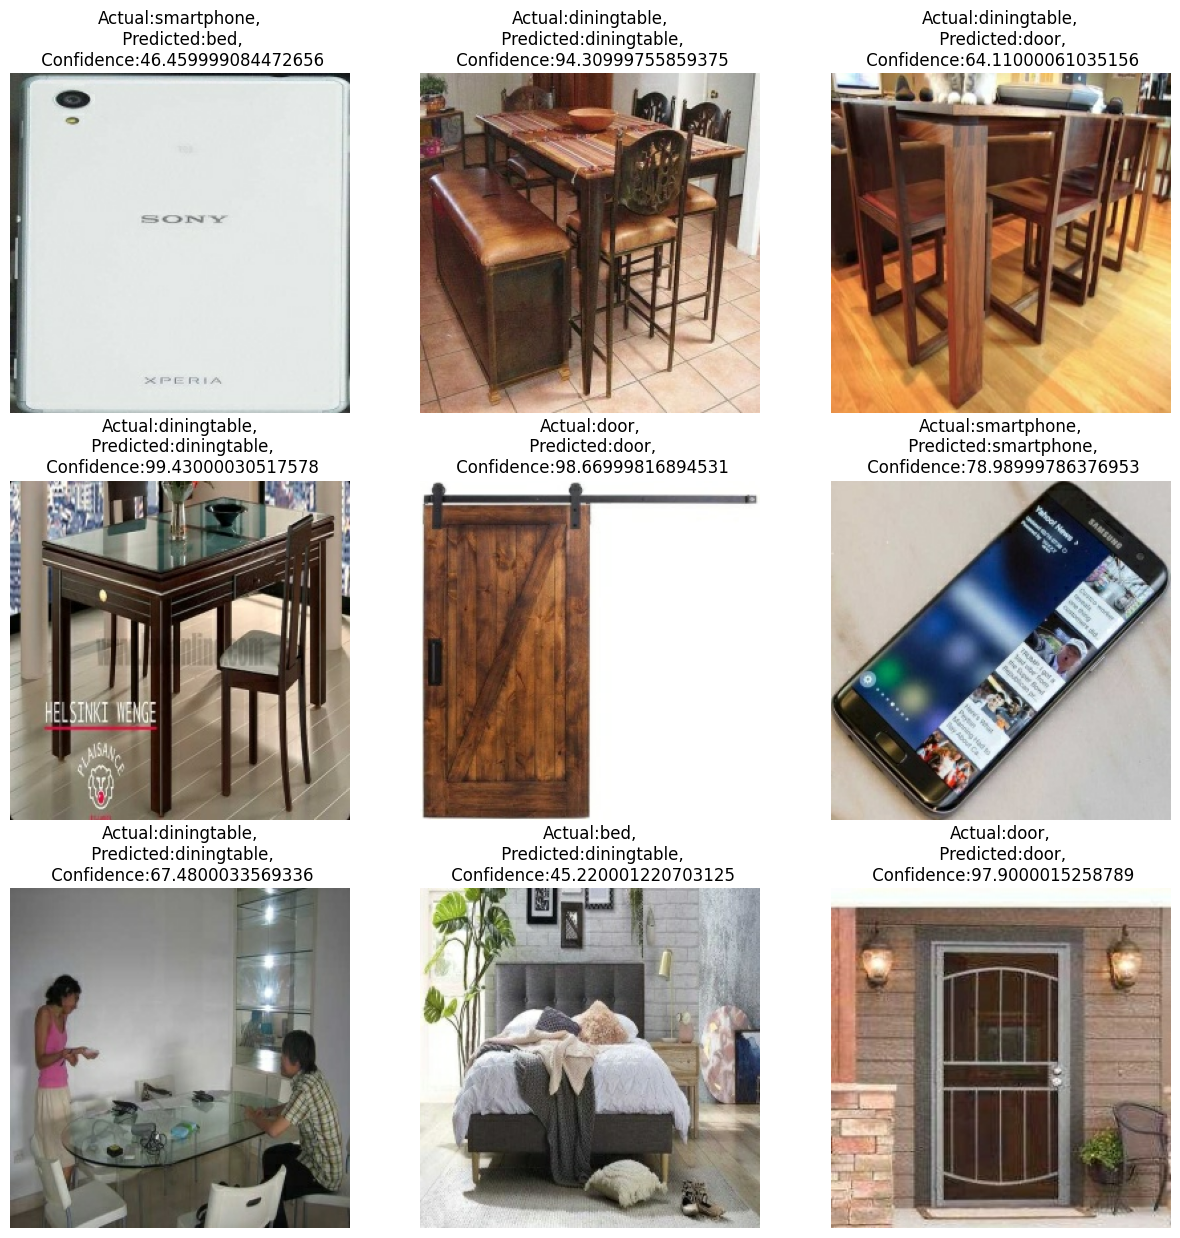

In [36]:
#Predict a bunch of images together
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i])
        actual_class=CLASS_NAMES[labels[i].numpy()]
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")
        plt.axis('off')


In [38]:
model_version=1
model.save(f"../models/model_{model_version}.keras")